# Imports and dataset loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.base import clone

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import MinMaxScaler
import autokeras as ak
import tensorflow as tf

ampNumber = 2

strategyArray = ["Amp {}".format(i + 1) for i in range(ampNumber)]
gainArray     = []
lossArray     = []

originalDataSet = pd.read_csv('dataset.txt', sep = ',',header = None)
originalDataSet = originalDataSet.sample(frac = 1, random_state = 5)
binaryDataSet   = []

import logging
tf.get_logger().setLevel(logging.ERROR)

for line in originalDataSet.values:
    myList = [1 if i != 0 else 0 for i in line[:40]]
    myList.extend(line[40:])
    binaryDataSet.append(myList)

binaryDataSet = pd.DataFrame(binaryDataSet)
gainScaler    = MinMaxScaler(feature_range = (-1, 1))
lossScaler    = MinMaxScaler(feature_range = (-1, 1))

gainScalerAux = []
lossScalerAux = []

for i in range(0, ampNumber * 2, 2):
    gainScalerAux.extend(binaryDataSet.values[:, 40 + i])
    lossScalerAux.extend(binaryDataSet.values[:, 40 + i + 1])

gainScaler.fit(np.array(gainScalerAux).reshape(-1, 1))
lossScaler.fit(np.array(lossScalerAux).reshape(-1, 1))

def loadDataset(): 
    dataSet = binaryDataSet.values[:, :40]
    
    for i in range(0, ampNumber * 2, 2):
        gain    = np.array(binaryDataSet.values[:, 40 + i])
        gain    = gainScaler.transform(gain.reshape(-1, 1))
        #gain    = gain.reshape(-1, 1)
        dataSet = np.hstack((dataSet, gain))
        
        loss    = np.array(binaryDataSet.values[:, 40 + i + 1])
        loss    = lossScaler.transform(loss.reshape(-1, 1))
        #loss    = loss.reshape(-1, 1)
        dataSet = np.hstack((dataSet, loss))
            
    X, y = np.array(dataSet[:, :40]), np.array(dataSet[:, 40:])
    
    return X, y

def invertGainNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return round(gainScaler.inverse_transform(auxArray)[0][0])

def invertLossNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return round(lossScaler.inverse_transform(auxArray)[0][0])
    
def getGainError(value1, value2):
    return abs(invertGainNorm(value1) - invertGainNorm(value2))

def getLossError(value1, value2):
    return abs(invertLossNorm(value1) - invertLossNorm(value2))

# Model setup

In [2]:
model = ak.StructuredDataRegressor(max_trials = 3, overwrite = False)

# Cross validation function

In [3]:
def crossValidate(regressor, X, y, folds = 5):
    foldSize   = math.ceil(X.shape[0] / folds)
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(X, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(y, np.s_[sliceBegin: sliceEnd], 0)
        
        regressor.fit(X_train, y_train, verbose = False)
        X_test = X[sliceBegin: sliceEnd]
        y_test = y[sliceBegin: sliceEnd]
        
        loss, acc = regressor.evaluate(X_test, y_test, verbose=0)
        print('Accuracy: %.3f' % acc)
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            for i in range(0, ampNumber * 2, 2):
                gainError += getGainError(predicted[i], expected[i]) 
                lossError += getLossError(predicted[i + 1], expected[i + 1])
                 
        gainErrors.append((gainError / ampNumber) / foldSize)
        lossErrors.append((lossError / ampNumber) / foldSize) # average loss error by amp
        
    return np.array(gainErrors), np.array(lossErrors)

In [4]:
def trainModel():   
    X, y                   = loadDataset()
    gainErrors, lossErrors = crossValidate(model, X, y)
    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(gainErrors), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)\n" % (np.mean(lossErrors), lossErrors.std() * 2))
    
    gainArray.append(gainErrors)
    lossArray.append(lossErrors)
    
    return gainErrors, lossErrors

# Plotting functions

In [5]:
def plotDistribution():
    train_results = []
    test_results  = []
    features, result                 = loadDataset()
    X_train, X_test, y_train, y_test = train_test_split(features, result, test_size = 0.3, random_state = 5)
    
    model.fit(X_train, y_train)
    train_results.append(model.predict(X_train))
    test_results.append(model.predict(X_test))
    
    fig   = plt.figure(figsize = (15, 5))
    vGain = np.vectorize(invertGainNorm)
    vLoss = np.vectorize(invertLossNorm)
    
    for i in range(ampNumber):
        ax = fig.add_subplot(2, 2, i + 1)
        
        yGain    = vGain(y_test[:, i * 2])
        yLoss    = vLoss(y_test[:, i * 2 + 1])
        testGain = vGain(test_results[0][:, i * 2])
        testLoss = vLoss(test_results[0][:, i * 2 + 1])
        
        ax.scatter(yGain, yLoss)
        ax.scatter(testGain, testLoss, c = "m")
        ax.set_title("Amplifier {}".format(i + 1))
    
    fig.suptitle("Test Error", fontsize = 16)
    fig.text(0.5, 0.04, 'Gain', ha='center', va='center', fontsize = 14)
    fig.text(0.06, 0.5, 'Loss', ha='center', va='center', rotation='vertical', fontsize = 14)
    fig.legend(["expected", "predicted"])

    plt.show()
    return y_test, test_results

In [6]:
def plotGainError(yTest, predicted):
    fig, axis = plt.subplots(figsize = (10, 5))
    data      = []
    
    for i in range(ampNumber):
        gainError = []
        
        yTestAmp     = yTest[:, i * 2]
        predictedAmp = predicted[0][:, i * 2]
        
        for a, b in zip(predictedAmp, yTestAmp):
            gainError.append(getGainError(a, b)) 
        
        data.append(gainError)
        
    axis.boxplot(data)
    axis.set_title("Test Gain Error", fontsize = 16)
    axis.set_xticklabels(np.repeat(strategyArray, 1))
    axis.set_ylabel("Absolute error (dB)", fontsize = 14)

    plt.show()

In [7]:
def plotLossError(yTest, predicted):
    fig, axis = plt.subplots(figsize = (10, 5))
    data      = []
    
    for i in range(ampNumber):
        lossError = []
        
        yTestAmp     = yTest[:, i * 2 + 1]
        predictedAmp = predicted[0][:, 1]
        
        for a, b in zip(predictedAmp, yTestAmp):
            lossError.append(getLossError(a, b)) 
        
        data.append(lossError)
        
    axis.boxplot(data)
    axis.set_title("Test Loss Error", fontsize = 16)
    axis.set_xticklabels(np.repeat(strategyArray, 1))
    axis.set_ylabel("Absolute error (dB)", fontsize = 14)

    plt.show()

In [8]:
def plotLinkTestError(yTest, predicted):
    fig, axis = plt.subplots(figsize = (10, 5))
    lossData  = [] 
    gainData  = [] 
    
    yTestGain     = yTest[:, 0]
    yTestLoss     = yTest[:, 1]
    predictedGain = np.array(predicted[0][:, 0]).flatten()
    predictedLoss = np.array(predicted[0][:, 1]).flatten()
    
    for i in range(1, ampNumber):
        yTestGain     = np.hstack((yTestGain, yTest[:, i * 2]))
        yTestLoss     = np.hstack((yTestLoss, yTest[:, i * 2 + 1]))
        predictedGain = np.hstack((predictedGain, np.array(predicted[0][:, i]).flatten()))
        predictedLoss = np.hstack((predictedLoss, np.array(predicted[0][:, i + 1]).flatten()))
    
    for i in range(len(yTestGain)):
        lossData.append(getLossError(predictedLoss[i], yTestLoss[i]))
        gainData.append(getGainError(predictedGain[i], yTestGain[i]))
            
    print("Loss error mean: {}. Loss error median: {}".format(np.mean(lossData), np.median(lossData)))
    print("Gain error mean: {}. Gain error median: {}".format(np.mean(gainData), np.median(gainData)))
    
    print(len(lossData), len(gainData))
    
    axis.boxplot([lossData, gainData])
    axis.set_title("Link Test Error", fontsize = 16)
    axis.set_xticklabels(["Gain", "Loss"])
    axis.set_ylabel("Absolute error (dB)", fontsize = 14)

    plt.show()

# Putting all together

In [9]:
gainArray = []
lossArray = []

In [10]:
trainModel()
print(model.export_model().summary())

Accuracy: 0.176
Accuracy: 0.170
Accuracy: 0.164
Accuracy: 0.168
Accuracy: 0.171
[1.82329843 1.76570681 1.81413613 1.78795812 1.78272251] => 1.79 (+/- 0.04)
[1.54712042 1.52879581 1.47905759 1.52094241 1.56282723] => 1.53 (+/- 0.06)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 40)                0         
_________________________________________________________________
normalization (Normalization (None, 40)                81        
_________________________________________________________________
dense (Dense)                (None, 256)               10496     
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
___________________

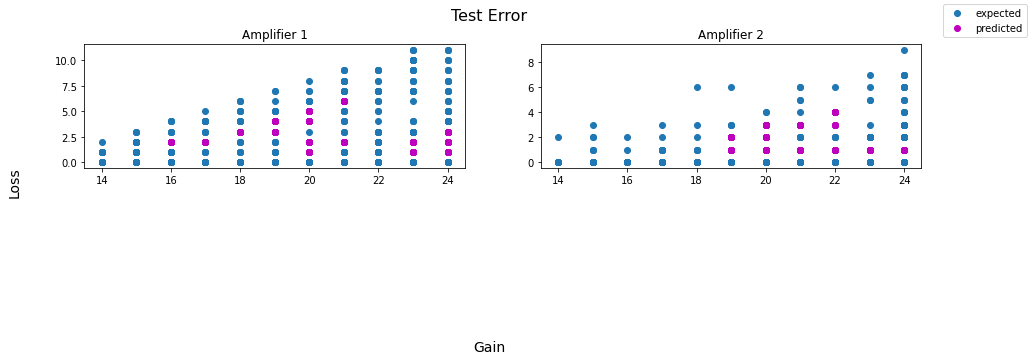

In [11]:
yTest, predicted = plotDistribution()

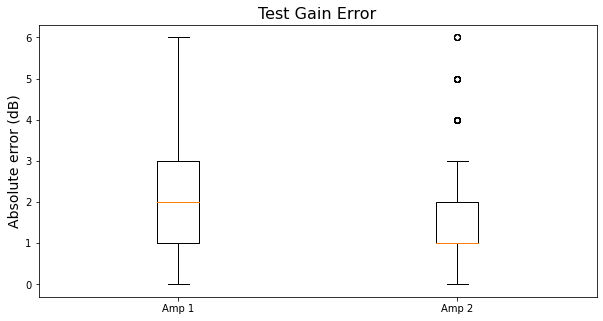

In [12]:
plotGainError(yTest, predicted)

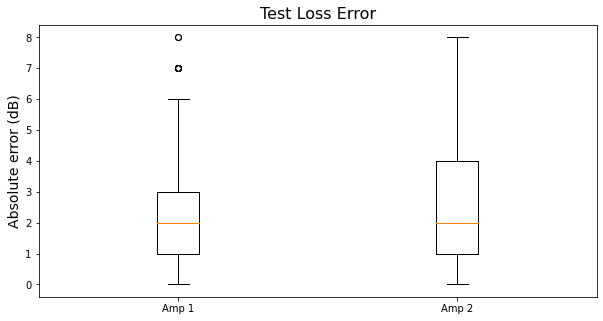

In [13]:
plotLossError(yTest, predicted)

Loss error mean: 5.022687609075043. Loss error median: 5.0
Gain error mean: 3.526178010471204. Gain error median: 3.0
1146 1146


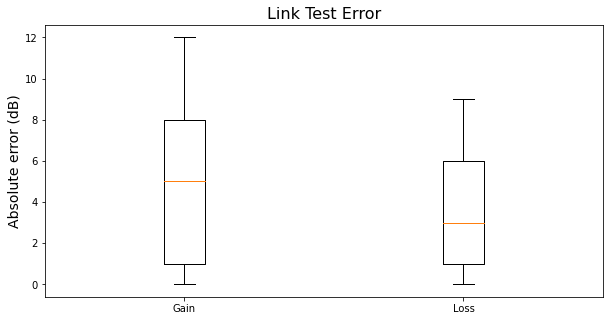

In [14]:
plotLinkTestError(yTest, predicted)